In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from math import e
import seaborn as sns
from collections import Counter
from scipy import odr
sns.set_style("whitegrid")

### Non-Homogenous CA for Earth quakes

**add_noise_to_values** and **generate_normal_distribution** are defined to induce asperities in the cells. **redistribute_force** and **simulate_ca** are defined to simulate the Cellular automata process.

In [2]:
def add_noise_to_values(values, noise_percentage):
    """
    Add random noise to an array of values.
    The noise is both positive and negative, given as a percentage of the actual values.

    :param values: Numpy array of original values.
    :param noise_percentage: The percentage of the original value by which to vary.
    :return: Numpy array with noise added.
    """
    # Calculate noise as a percentage of each value
    noise = np.random.uniform(-noise_percentage, noise_percentage, values.shape) / 100.0
    noisy_values = values + (values * noise) # Add noise to the original values
    return noisy_values

def generate_normal_distribution(size, mean, std, lower_limit):
    """
    Generate an array of values with a given size, mean, and standard deviation,
    with the constraint that all values are above a specified lower limit.

    :param size: Size of the array to generate.
    :param mean: Mean value of the normal distribution.
    :param std: Standard deviation of the normal distribution.
    :param lower_limit: The lower limit for the values.
    :return: Numpy array of generated values.
    """
    values = np.random.normal(mean, std, size) # Generate values from a normal distribution

    # Ensure all values are above the lower limit
    values = np.maximum(values, lower_limit)

    return values

def redistribute_force(F, L, alpha, F_thr, F_res, neighborhood='moore'):
    """
    Redistribute force among the square lattice according to OFC model for moore and von nueman neighborhood criteria.
    Returns the new force array and the list of active sites.

    :param F: array of forces stored in the lattice.
    :param L: Size of the lattice (number of cells along one side of the square grid).
    :param alpha: fraction of force to redistribute.
    :param F_thr: array of thresholds for lattice cells.
    :param F_res: array of residual forces for lattice cells.
    :param neighborhood: Specifies the type of neighborhood for force redistribution
    :return: Numpy array of new forces array and number of active sites of the previous configuration.
    """
    F_new = np.copy(F) # Copying the force array to a new array
    # active_sites = [] # array of active sites(forces above threshold)

    # for i in range(L):
    #     for j in range(L):
    #         if F[i, j] >= F_thr[i, j]:  # Use individual cell thresholds
    #             active_sites.append((i, j))

    active_mask = F >= F_thr

    # Use np.argwhere to find the indices where the condition is True
    active_sites = np.argwhere(active_mask)

    # Convert the indices to a list of tuples
    active_sites = list(map(tuple, active_sites))

    for site in active_sites:
        i, j = site
        force_to_redistribute = F[i, j] - F_res[i, j] # Force to redistribute

        if neighborhood == 'moore':
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1),
                         (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
            neighbors_count = 8
        else:
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
            neighbors_count = 4

        neighbors_count = sum(1 for ni, nj in neighbors if 0 <= ni < L and 0 <= nj < L) # Counting the number of neighbors
        
        for ni, nj in neighbors:
            if 0 <= ni < L and 0 <= nj < L:
                F_new[ni, nj] += (alpha * force_to_redistribute) / neighbors_count # Redistributing the force to the neighbors

        F_new[i, j] = F_res[i,j]  # Resetting the active site to a residual force

    return F_new, active_sites

def simulate_ca(L, alpha, mean_thr, std_thr, min_thr, mean_res, std_res, min_res, n_additions, neighborhood='moore'):
    """
    Simulate a Cellular Automaton model over a lattice.

    :param L: Size of the lattice (number of cells along one side of the square grid).
    :param alpha: Scaling factor used in the force redistribution process.
    :param mean_thr, std_thr, min_thr: Parameters for the distribution of threshold forces.
    :param mean_res, std_res, min_res: Parameters for the distribution of residual forces.
    :param n_additions: Number of iterations to perform in adding force to the system.
    :param neighborhood: Specifies the type of neighborhood for force redistribution.
    :return: Initial state, final state, and array of active site counts.
    """
    F = np.random.rand(L, L) * mean_thr
    initial_state = np.copy(F)
    total_additions = n_additions

    # F_thr = add_noise_to_values(np.full((L, L), mean_thr), noise_thr)
    # F_res = add_noise_to_values(np.full((L, L), mean_res), noise_res)

    F_thr = generate_normal_distribution((L, L), mean_thr, std_thr, min_thr)
    F_res = generate_normal_distribution((L, L), mean_res, std_res, min_res)

    active = True
    active_sites_count = 0
    active_sites_array = []
    avalanche_sequences = []
    current_avalanche = []
    while active:
        F, active_sites = redistribute_force(F, L, alpha, F_thr, F_res, neighborhood)
        active = len(active_sites) > 0
        active_sites_count += len(active_sites)
        current_avalanche.append(len(active_sites))

        if not active and n_additions > 0:
            i, j = np.unravel_index(np.argmin(F_thr - F), F.shape)
            F += (F_thr[i, j] - F[i, j])
            
            if n_additions != total_additions:
                active_sites_array.append(active_sites_count)
                avalanche_sequences.append(current_avalanche)
            n_additions -= 1
            active_sites_count = 0
            current_avalanche = []
            active = True

    # add the data for last addition
    active_sites_array.append(active_sites_count)
    avalanche_sequences.append(current_avalanche)

    return initial_state, F, active_sites_array, avalanche_sequences

def visualize_states(initial_state, final_state, title='Cellular Automata States'):
    """
    Visualize the initial and final states of a Cellular Automaton model.

    :param initial_state: Numpy array of initial state.
    :param final_state: Numpy array of final state.
    :param title: Title for the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1 = axes[0]
    im1 = ax1.imshow(initial_state, cmap='viridis', interpolation='nearest')
    ax1.set_title('Initial State')
    fig.colorbar(im1, ax=ax1, orientation='vertical')
    ax2 = axes[1]
    im2 = ax2.imshow(final_state, cmap='viridis', interpolation='nearest')
    ax2.set_title('Final State')
    fig.colorbar(im2, ax=ax2, orientation='vertical')
    plt.suptitle(title)
    plt.show()

In [3]:
# Orthogonal Distance Regression（ODR）
def linear_func(p, x):
    """This function is designed to do the linear regression. 
    It returns the slope and the intercept
    """
    a, b = p
    return a * x + b

In [4]:
# Parameters
L = 50  # Size of the lattice
alpha = 0.5  # Coupling constant
mean_thr = 5  # Mean threshold
std_thr = 0.2  # std dev of threshold
min_thr = 3.0  # Minimum threshold
mean_res = 0  # Mean residual force
std_res = 0 # std dev of residual force
min_res = 0  # Minimum residual force
n_additions = 50000  # Number of additions

### Test run for non homogenous CA

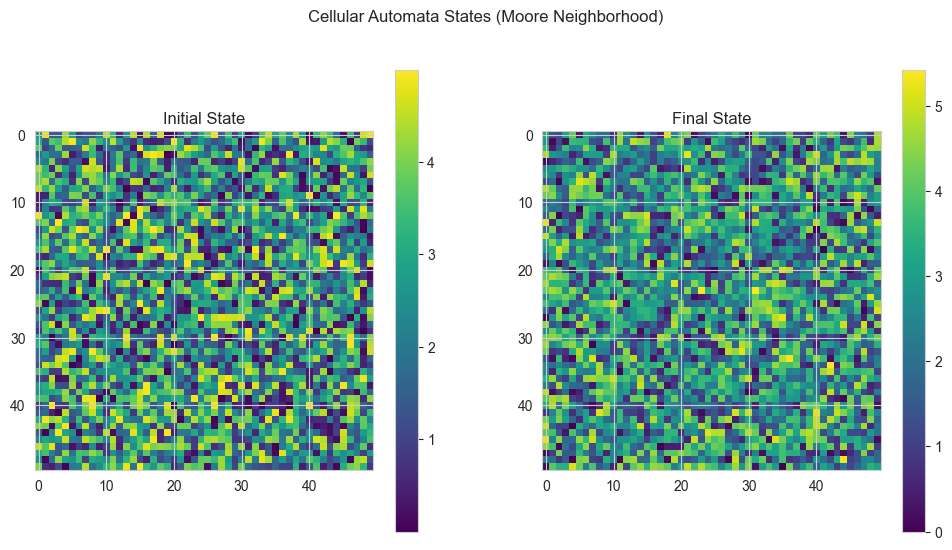

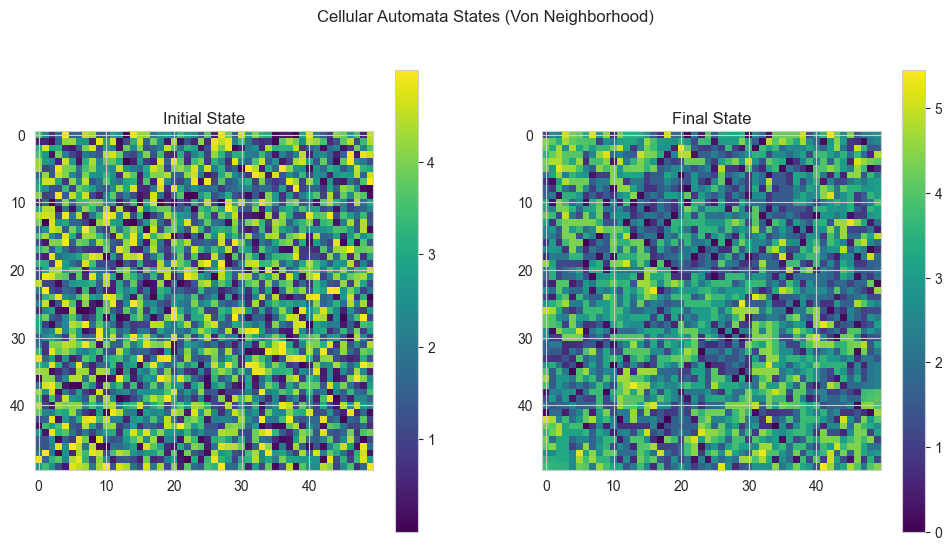

In [5]:
# Run the simulation
initial_state, final_state, active_sites_array, avalanche_sequences = simulate_ca(L, alpha, mean_thr, std_thr, min_thr, mean_res, std_res, min_res, n_additions, neighborhood='moore')

# Visualize the initial and final states
visualize_states(initial_state, final_state, title='Cellular Automata States (Moore Neighborhood)')

initial_state, final_state, active_sites_array, avalanche_sequences = simulate_ca(L, alpha, mean_thr, std_thr, min_thr, mean_res, std_res, min_res, n_additions, neighborhood='von')

# Visualize the initial and final states
visualize_states(initial_state, final_state, title='Cellular Automata States (Von Neighborhood)')

Running simulation for alpha=0.7, L=15, Threshold=4.0...
10% 

20% 30% 40% 50% 60% 70% 80% 90% 100% 

Running simulation for alpha=0.7, L=25, Threshold=4.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

Running simulation for alpha=0.7, L=50, Threshold=4.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

Running simulation for alpha=0.7, L=100, Threshold=4.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

Running simulation for alpha=0.7, L=200, Threshold=4.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 



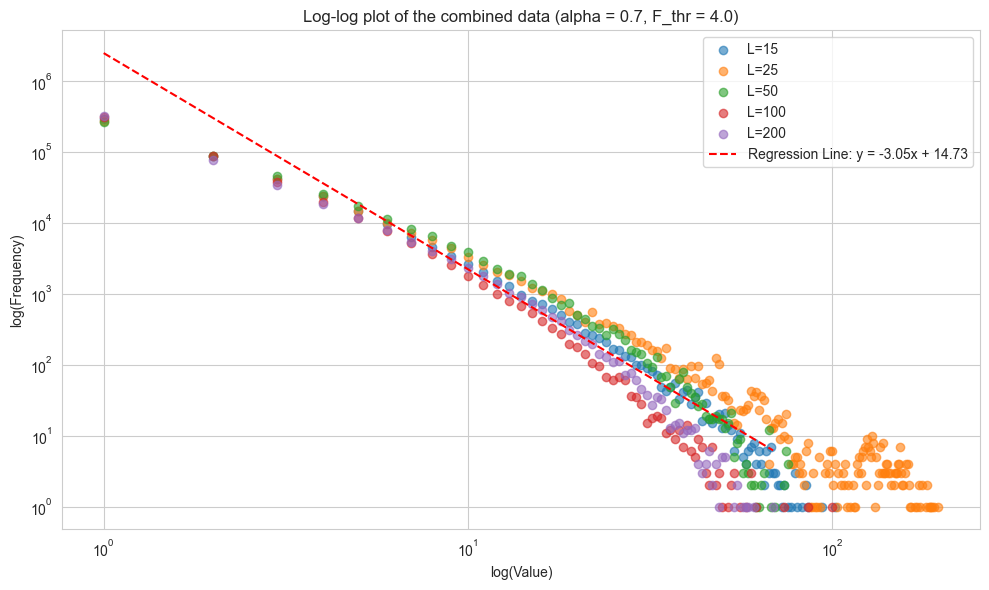

In [10]:
# Parameters
alphas = [0.7]  # Varying values for alpha
L_values = [15, 25, 50, 100, 200]     # Varying values for L
thresholds = [4.0] # Varying values for threshold
additions = [10000, 20000, 30000] # Varying values for number of additions
simulations = [1, 10, 20] # Varying values for number of simulations
stdevs = [0.0] # Varying values for standard deviation of threshold
mean_thr = 2  # Mean threshold
std_thr = 0.01  # std dev of threshold
min_thr = 1  # Minimum threshold
mean_res = 0  # Mean residual force
std_res = 0 # std dev of residual force
min_res = 0  # Minimum residual force

n_additions = 50000  # Number of additions of force to the system

# Number of simulations
n_simulations = 10

# Create a 3x3 plot grid
fig, axes = plt.subplots(figsize=(10, 6))
full_values = []
full_frequencies = []

for i, alpha in enumerate(alphas):
    for j, mean_thr in enumerate(thresholds):
        for k, L in enumerate(L_values):
            print(f"Running simulation for alpha={alpha}, L={L}, Threshold={mean_thr}...")
            
            # Arrays to store results of each simulation
            active_sites_moore_array = []

            for z in range(n_simulations):
                print(round((z+1)/n_simulations*100),"%", sep='', end=' ', flush=True)
                #_, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, 'moore')
                _, _, active_sites_moore,_ = simulate_ca(L, alpha, mean_thr, std_thr, min_thr, mean_res, std_res, min_res, n_additions, neighborhood='moore')
                active_sites_moore_array = np.append(active_sites_moore_array, active_sites_moore)

            # Compute the average of the results
            # average_active_sites_moore = np.mean(active_sites_moore_array, axis=0)
            
            # Process data
            occurrences_counter = Counter(active_sites_moore_array)
            magnitudes = list(occurrences_counter.keys())
            frequencies = list(occurrences_counter.values())
            values = np.array(list(occurrences_counter.keys()))
            frequencies = np.array(list(occurrences_counter.values()))
            # frequencies = frequencies / np.sum(frequencies)

            non_zero_indices = values > 0
            values = values[non_zero_indices]
            frequencies = frequencies[non_zero_indices]
            full_values = np.append(full_values, values)
            full_frequencies = np.append(full_frequencies, frequencies)
            
            plt.scatter(values, frequencies, label=f'L={L}', alpha=0.6)
            print("\n")

# Use ODR to do Linear Regression
linear_model = odr.Model(linear_func)
data = odr.Data(np.log(full_values), np.log(full_frequencies))
odr_obj = odr.ODR(data, linear_model, beta0=[0., 1.])
output = odr_obj.run()

slope, intercept = output.beta
r_squared = output.res_var
p_value = output.cov_beta[0, 0]
std_err = output.sd_beta

x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
y = slope * x + intercept
plt.plot(e ** x, e ** y, color='red', linestyle='--', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

# Set plot labels and title
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Log-log plot of the combined data (alpha = {alpha}, F_thr = {mean_thr})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Running simulation for alpha=0.25, L=50, Threshold=4.0...
10% 

20% 30% 40% 50% 60% 70% 80% 90% 100% 

Running simulation for alpha=0.5, L=50, Threshold=4.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

Running simulation for alpha=0.75, L=50, Threshold=4.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 



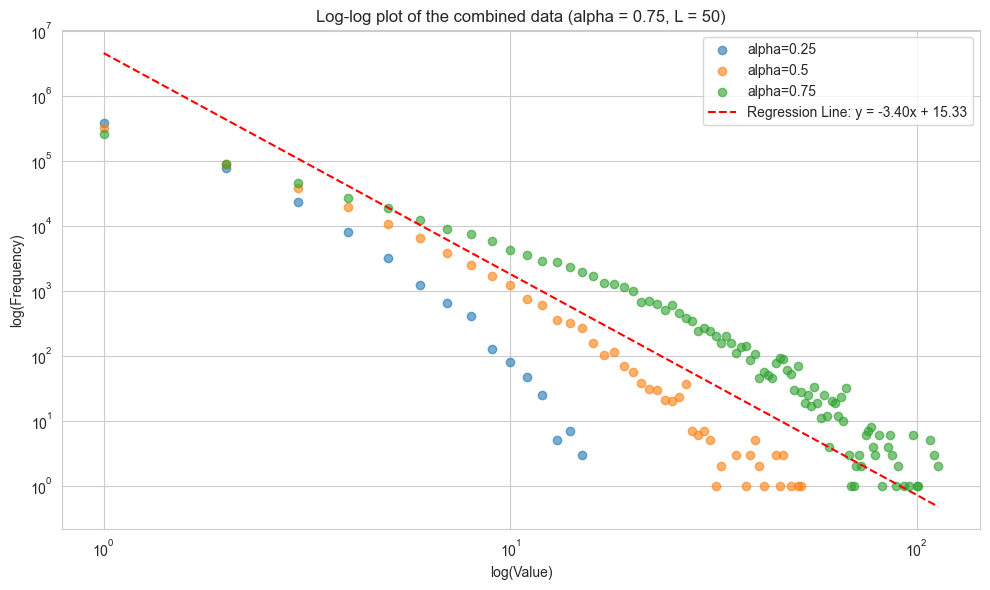

In [ ]:
# Parameters
alphas = [0.25, 0.5, 0.75]  # Varying values for alpha
L_values = [50]     # Varying values for L
thresholds = [4.0] # Varying values for threshold
additions = [10000, 20000, 30000] # Varying values for number of additions
simulations = [1, 10, 20] # Varying values for number of simulations
stdevs = [0.0] # Varying values for standard deviation of threshold
mean_thr = 2  # Mean threshold
std_thr = 0.01  # std dev of threshold
min_thr = 1  # Minimum threshold
mean_res = 0  # Mean residual force
std_res = 0 # std dev of residual force
min_res = 0  # Minimum residual force

n_additions = 50000  # Number of additions of force to the system

# Number of simulations
n_simulations = 10

# Create a 3x3 plot grid
fig, axes = plt.subplots(figsize=(10, 6))
full_values = []
full_frequencies = []

for i, alpha in enumerate(alphas):
    for j, mean_thr in enumerate(thresholds):
        for k, L in enumerate(L_values):
            print(f"Running simulation for alpha={alpha}, L={L}, Threshold={mean_thr}...")
            
            # Arrays to store results of each simulation
            active_sites_moore_array = []

            for z in range(n_simulations):
                print(round((z+1)/n_simulations*100),"%", sep='', end=' ', flush=True)
                #_, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, 'moore')
                _, _, active_sites_moore,_ = simulate_ca(L, alpha, mean_thr, std_thr, min_thr, mean_res, std_res, min_res, n_additions, neighborhood='moore')
                active_sites_moore_array = np.append(active_sites_moore_array, active_sites_moore)

            # Compute the average of the results
            # average_active_sites_moore = np.mean(active_sites_moore_array, axis=0)
            
            # Process data
            occurrences_counter = Counter(active_sites_moore_array)
            magnitudes = list(occurrences_counter.keys())
            frequencies = list(occurrences_counter.values())
            values = np.array(list(occurrences_counter.keys()))
            frequencies = np.array(list(occurrences_counter.values()))
            # frequencies = frequencies / np.sum(frequencies)

            non_zero_indices = values > 0
            values = values[non_zero_indices]
            frequencies = frequencies[non_zero_indices]
            full_values = np.append(full_values, values)
            full_frequencies = np.append(full_frequencies, frequencies)

            
            plt.scatter(values, frequencies, label=f'alpha={alpha}', alpha=0.6)
            print("\n")

# Use ODR to do Linear Regression
linear_model = odr.Model(linear_func)
data = odr.Data(np.log(full_values), np.log(full_frequencies))
odr_obj = odr.ODR(data, linear_model, beta0=[0., 1.])
output = odr_obj.run()

slope, intercept = output.beta
r_squared = output.res_var
p_value = output.cov_beta[0, 0]
std_err = output.sd_beta

x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
y = slope * x + intercept
plt.plot(e ** x, e ** y, color='red', linestyle='--', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

# Set plot labels and title
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Log-log plot of the combined data (alpha = {alpha}, L = {L})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Running simulation for alpha=0.5, L=100, Threshold=4...
10% 

20% 30% 40% 50% 60% 70% 80% 90% 100% 

Running simulation for alpha=0.5, L=100, Threshold=10...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

Running simulation for alpha=0.5, L=100, Threshold=20...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 



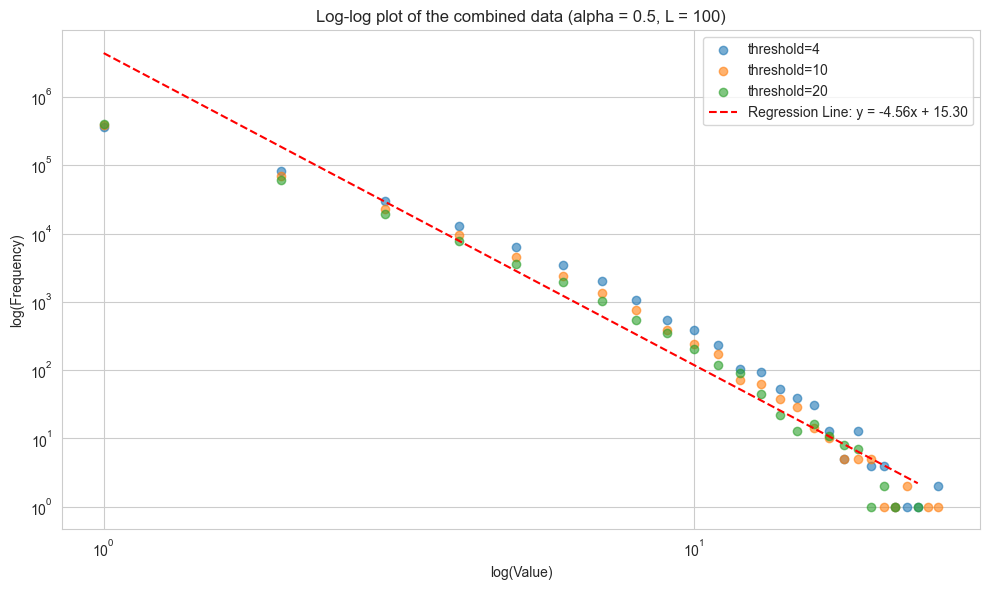

In [ ]:
# Parameters
alphas = [0.5]  # Varying values for alpha
L_values = [100]     # Varying values for L
thresholds = [4, 10, 20]  # Varying values for threshold
additions = [10000, 20000, 30000] # Varying values for number of additions
simulations = [1, 10, 20] # Varying values for number of simulations
stdevs = [0.0] # Varying values for standard deviation of threshold
mean_thr = 2  # Mean threshold
std_thr = 0.01  # std dev of threshold
min_thr = 1  # Minimum threshold
mean_res = 0  # Mean residual force
std_res = 0 # std dev of residual force
min_res = 0  # Minimum residual force

n_additions = 50000  # Number of additions of force to the system

# Number of simulations
n_simulations = 10

# Create a 3x3 plot grid
fig, axes = plt.subplots(figsize=(10, 6))
full_values = []
full_frequencies = []

for i, alpha in enumerate(alphas):
    for j, mean_thr in enumerate(thresholds):
        for k, L in enumerate(L_values):
            print(f"Running simulation for alpha={alpha}, L={L}, Threshold={mean_thr}...")
            
            # Arrays to store results of each simulation
            active_sites_moore_array = []

            for z in range(n_simulations):
                print(round((z+1)/n_simulations*100),"%", sep='', end=' ', flush=True)
                #_, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, 'moore')
                _, _, active_sites_moore,_ = simulate_ca(L, alpha, mean_thr, std_thr, min_thr, mean_res, std_res, min_res, n_additions, neighborhood='moore')
                active_sites_moore_array = np.append(active_sites_moore_array, active_sites_moore)

            # Compute the average of the results
            # average_active_sites_moore = np.mean(active_sites_moore_array, axis=0)
            
            # Process data
            occurrences_counter = Counter(active_sites_moore_array)
            magnitudes = list(occurrences_counter.keys())
            frequencies = list(occurrences_counter.values())
            values = np.array(list(occurrences_counter.keys()))
            frequencies = np.array(list(occurrences_counter.values()))
            # frequencies = frequencies / np.sum(frequencies)

            non_zero_indices = values > 0
            values = values[non_zero_indices]
            frequencies = frequencies[non_zero_indices]
            full_values = np.append(full_values, values)
            full_frequencies = np.append(full_frequencies, frequencies)
            
            plt.scatter(values, frequencies, label=f'threshold={mean_thr}', alpha=0.6)
            print("\n")

# Use ODR to do Linear Regression
linear_model = odr.Model(linear_func)
data = odr.Data(np.log(full_values), np.log(full_frequencies))
odr_obj = odr.ODR(data, linear_model, beta0=[0., 1.])
output = odr_obj.run()

slope, intercept = output.beta
r_squared = output.res_var
p_value = output.cov_beta[0, 0]
std_err = output.sd_beta

x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
y = slope * x + intercept
plt.plot(e ** x, e ** y, color='red', linestyle='--', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

# Set plot labels and title
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Log-log plot of the combined data (alpha = {alpha}, L = {L})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()